# Importing Libraries

In [3]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close
from Git import *

In [4]:
# %run "Git.ipynb".ipynb

In [5]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [8]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [9]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [11]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [12]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [13]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [14]:
#trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))
price=Pnl_calculation.get_trade_in_usdt(trade_history)

In [15]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [16]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_12132\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [17]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [18]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [19]:
holding=Binance.get_inventory()

In [20]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100

pnl.sort_values(ascending=False,by='Price in USDT').round(2)


,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,2316.84,1793.55,1.00,-131.89,-391.40,-523.29,-22.59
BTCUSDT,601.02,928.83,0.52,3.54,327.81,331.35,14.30
SOLUSDT,281.20,259.52,0.14,0.00,-21.68,-21.68,-0.94
ETHUSDT,250.75,174.96,0.10,0.00,-75.79,-75.79,-3.27
JASMYUSDT,387.46,167.46,0.09,0.00,-220.00,-220.00,-9.50
TRXUSDT,76.87,130.52,0.07,-10.72,53.65,42.93,1.85
OMUSDT,526.32,119.81,0.07,0.00,-406.51,-406.51,-17.55
BBUSDT,60.18,11.34,0.01,-39.73,-48.84,-88.57,-3.82
BNBUSDT,1.14,1.11,0.00,-10.61,-0.04,-10.65,-0.46
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52,-1.66


In [21]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

60

In [22]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [23]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [24]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [25]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [26]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [27]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [29]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: 3065975bbbc48fda58cbda194e57961baa06a0f8)
✅ File pushed/updated successfully!


In [30]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [31]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [32]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [33]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: d0c26a34352b050a104a0780b38c84c2a8d61579)
✅ File pushed/updated successfully!


In [34]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [35]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [36]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [37]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [38]:
# pnl_history['Total']

In [39]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [40]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [41]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [42]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [43]:
pnl_history['Total']

2024-09-23   -242.846960
2024-09-24   -351.229838
2024-09-25   -362.331965
2024-09-26   -276.632747
2024-09-27   -260.113627
                 ...    
2025-06-08   -463.491441
2025-06-09   -379.235084
2025-06-10   -348.440020
2025-06-11   -401.958976
2025-06-12   -347.154130
Name: Total, Length: 263, dtype: float64

<Axes: >

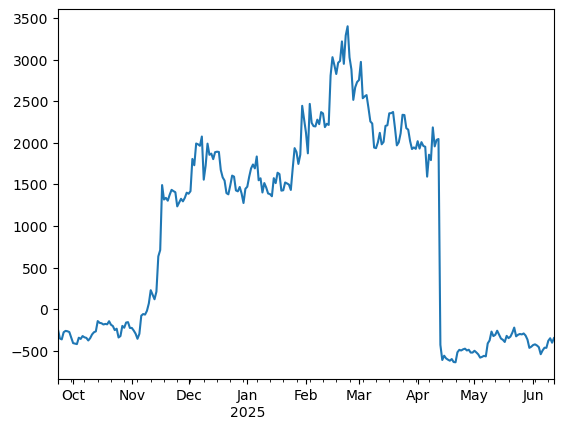

In [44]:
pnl_history['Total'].plot()

In [45]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-06-08     -1.057993
2025-06-09     84.256356
2025-06-10     30.795064
2025-06-11    -53.518956
2025-06-12     54.804846
Name: Total, Length: 263, dtype: float64

In [46]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-398.19781946423717, -1142.8435479265506)

In [47]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [48]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [49]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [50]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [51]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [52]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [53]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

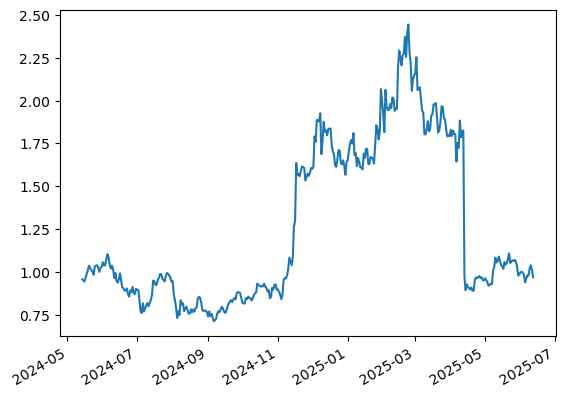

In [54]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

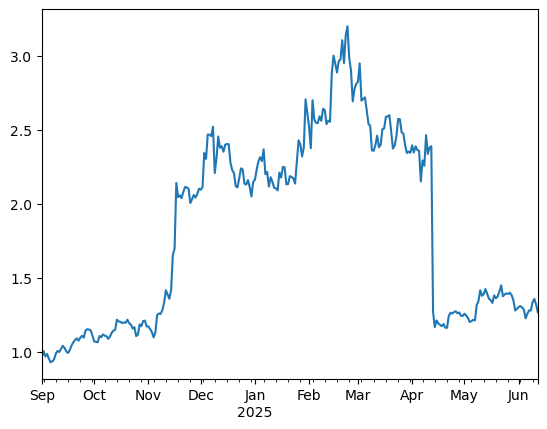

In [55]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [57]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [60]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [61]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [64]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
PAXGUSDT,0.8162
BNBUSDT,0.0487
TRXUSDT,0.0377
BTCUSDT,0.0212
AAVEUSDT,0.0200
SUIUSDT,0.0172
PEPEUSDT,0.0130
OMUSDT,0.0128
XRPUSDT,0.0128
WBTCUSDT,0.0003


In [65]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
PAXGUSDT,0.654827
BTCUSDT,0.300000
TRXUSDT,0.034272
OMUSDT,0.010901


In [66]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

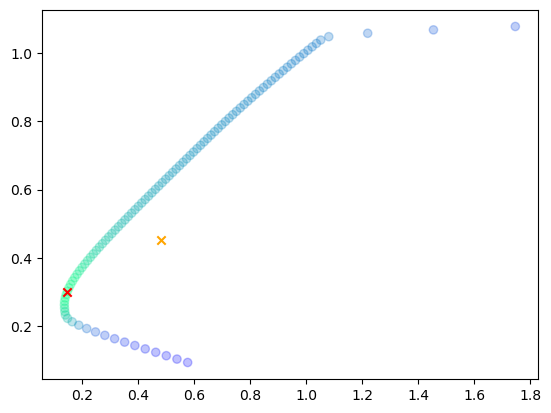

In [67]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [68]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [69]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,928.833955,0.517874,0.0297,0.488174
SOLUSDT,259.524727,0.144699,0.0000,0.144699
ETHUSDT,174.961959,0.097551,0.0000,0.097551
JASMYUSDT,167.459085,0.093367,0.0000,0.093367
TRXUSDT,130.520927,0.072772,0.0217,0.051072
OMUSDT,119.805126,0.066798,0.0068,0.059998
BBUSDT,11.338548,0.006322,0.0000,0.006322
BNBUSDT,1.107116,0.000617,0.0610,-0.060383
PEPEUSDT,0.000003,0.000000,0.0171,-0.017100
PAXGUSDT,0.000000,0.000000,0.4028,-0.402800


### Current results

In [71]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [72]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
PAXGUSDT,0.850873
BTCUSDT,0.093360
TRXUSDT,0.055767


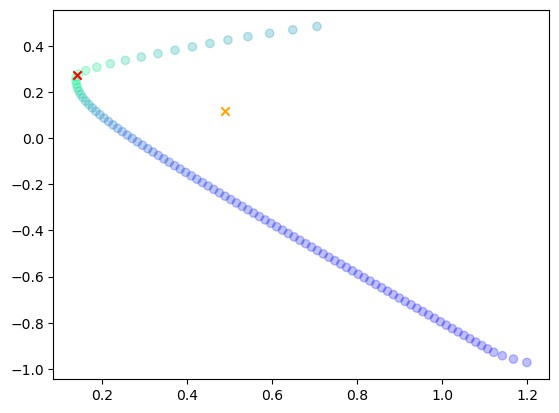

In [73]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [74]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,928.833955,0.517874,0.093360,0.424514
SOLUSDT,259.524727,0.144699,0.000000,0.144699
ETHUSDT,174.961959,0.097551,0.000000,0.097551
JASMYUSDT,167.459085,0.093367,0.000000,0.093367
TRXUSDT,130.520927,0.072772,0.055767,0.017005
OMUSDT,119.805126,0.066798,0.000000,0.066798
BBUSDT,11.338548,0.006322,0.000000,0.006322
BNBUSDT,1.107116,0.000617,0.000000,0.000617
PEPEUSDT,0.000003,0.000000,0.000000,0.000000
PAXGUSDT,0.000000,0.000000,0.850873,-0.850873


# Risk Reward Analysis

In [76]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [77]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

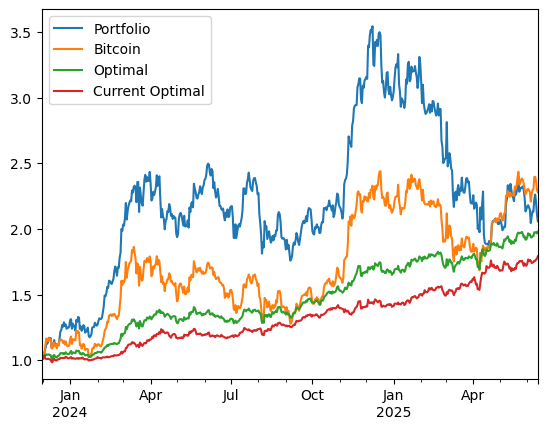

In [78]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [79]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

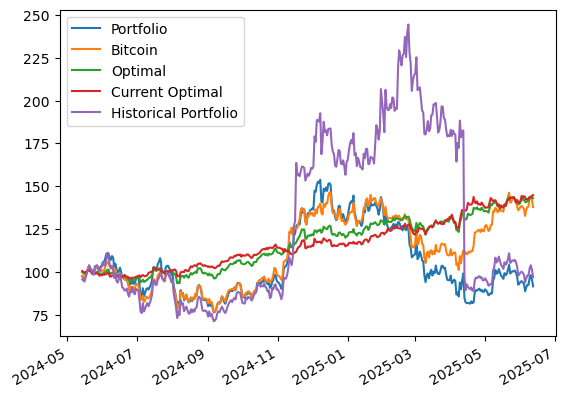

In [80]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


In [81]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-06-03,93.941932,137.769288,142.099037,143.366868,99.420893
2025-06-04,92.965038,136.877339,142.436975,144.189160,98.339966
2025-06-05,88.681577,132.644433,140.798437,143.642932,93.820926
2025-06-06,90.945233,136.227982,140.647484,142.152681,96.220638
2025-06-07,92.520934,137.868797,141.297019,142.511489,97.902913
2025-06-08,92.474399,138.106119,141.493020,142.692483,97.851234
2025-06-09,96.603178,143.898579,143.575394,143.606530,102.207699
2025-06-10,98.080286,143.913417,143.506335,143.536253,103.839721
2025-06-11,95.426543,141.771277,143.628895,144.393103,100.995838
2025-06-12,91.523735,137.837210,142.978976,144.844613,96.861268


## Volatilities

In [83]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.17405
 dtype: float64,
 0.1742031932518251)

In [84]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.48847
 dtype: float64,
 0.48846954788502717)

In [85]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.484936
Bitcoin            0.423282
Optimal            0.174203
Current Optimal    0.138277
dtype: float64

In [86]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.5703660013118411

In [87]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

-2.281394767614588

In [88]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.2406437386370975

## Risk Contribution

In [90]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
PAXGUSDT,43.9189,0.3253,0.2882,0.0370
BTCUSDT,38.3963,0.6039,0.5314,0.0725
TRXUSDT,2.7783,0.0371,0.0146,0.0225
OMUSDT,-12.3221,0.0338,0.0120,0.0218
Portfolio,72.7715,1.0000,0.8461,0.1539


In [91]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
PAXGUSDT,39.666830,0.790296,0.760454,0.029842
BTCUSDT,4.353925,0.111012,0.072504,0.038508
TRXUSDT,2.982841,0.098692,0.078258,0.020434
Portfolio,47.003596,1.000000,0.911216,0.088784


In [92]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
test=current_risk.perf_contrib(current_weights)

# Value At Risk

## Historical

### Optimal Weights

In [96]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.027285718939269236, -0.03538414927439105)

### Current Weights

In [98]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.08252140301035794, -0.10806637948973506)

In [99]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [100]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.020097
SOLUSDT     -0.012594
ETHUSDT     -0.007576
JASMYUSDT   -0.015337
TRXUSDT     -0.013385
OMUSDT      -0.011288
BBUSDT      -0.002231
BNBUSDT     -0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.082508
Name: 2024-12-09 00:00:00, dtype: float64

In [101]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.026942
SOLUSDT     -0.018062
ETHUSDT     -0.010221
JASMYUSDT   -0.011521
TRXUSDT     -0.003734
OMUSDT      -0.030778
BBUSDT      -0.001697
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.102955
dtype: float64

## Parametric

### Optimal Weights

In [104]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.02552880578619983, -0.031619095950148494)

### Current Weights

In [106]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.07158332742157728, -0.08866063368296215)

## Multivariate

### Optimal Weights

In [109]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.024492480981758935, -0.027757761189138374)

### Current Weights

In [111]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06872389217678962, -0.08042120778975231)

In [112]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.027843
SOLUSDT     -0.012187
ETHUSDT     -0.007568
JASMYUSDT   -0.011061
TRXUSDT     -0.002228
OMUSDT      -0.009254
BBUSDT      -0.001186
Portfolio   -0.071327
dtype: float64

In [113]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.027308
SOLUSDT     -0.011911
ETHUSDT     -0.007762
JASMYUSDT   -0.011820
TRXUSDT     -0.002359
OMUSDT      -0.009894
BBUSDT      -0.001304
Portfolio   -0.072359
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [117]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.024714720991388446, -0.02832465018954192)

### Current Weights

In [119]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0704935726966991, -0.08085538827891187)

In [120]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [123]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.024720561075953155, -0.02843909271850704)

### Current Weights

In [125]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07193322882944159, -0.08287362732021025)

In [126]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [129]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05769387099010295, -0.07109184002531173)

### Current Weights

In [131]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.09697783339398515, -0.11680315121935005)

In [132]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [135]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [136]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.025395015873509116, -0.029209340852162088)

### Current Weights

In [138]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0715099221330669, -0.08035395999807012)

In [139]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [140]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.033846,-0.028378,-0.019555,-0.027843,-0.028883
SOLUSDT,-0.007432,-0.012953,-0.009309,-0.012187,-0.012648
ETHUSDT,-0.002625,-0.007917,-0.005469,-0.007568,-0.008084
JASMYUSDT,-0.005263,-0.010784,-0.007977,-0.011061,-0.010914
TRXUSDT,-0.001855,-0.002024,-0.001747,-0.002228,-0.002312
OMUSDT,-0.012619,-0.007729,-0.006829,-0.009254,-0.008733
BBUSDT,-0.000263,-0.001298,-0.000812,-0.001186,-0.001361
Portfolio,-0.063902,-0.071084,-0.051697,-0.071327,-0.072935


In [141]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.035838,-0.028797,-0.019284,-0.027308,-0.028487
SOLUSDT,-0.006929,-0.013050,-0.009772,-0.011911,-0.013124
ETHUSDT,-0.002326,-0.008144,-0.005414,-0.007762,-0.008131
JASMYUSDT,-0.006118,-0.010677,-0.008671,-0.011820,-0.011438
TRXUSDT,-0.002637,-0.002287,-0.001766,-0.002359,-0.002014
OMUSDT,-0.010152,-0.007610,-0.006511,-0.009894,-0.009294
BBUSDT,-0.000466,-0.001350,-0.000835,-0.001304,-0.001403
Portfolio,-0.064466,-0.071915,-0.052254,-0.072359,-0.073890


## VaR Violation

In [143]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.020855,-0.021163,-0.020253,-0.007768
2024-01-15,-0.020855,-0.021589,-0.020258,0.010679
2024-01-16,-0.020855,-0.021437,-0.020055,-0.001686
2024-01-17,-0.020855,-0.021105,-0.020897,-0.007334
2024-01-18,-0.020855,-0.021352,-0.021141,-0.007200
...,...,...,...,...
2025-06-09,-0.014358,-0.021689,-0.021086,0.014717
2025-06-10,-0.014358,-0.021207,-0.020132,-0.000481
2025-06-11,-0.014358,-0.020358,-0.018310,0.000854
2025-06-12,-0.014358,-0.020328,-0.019320,-0.004525


In [144]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.025562,-0.078194,-0.073032,-0.016167
2024-05-29,-0.018664,-0.075979,-0.066057,-0.009756
2024-05-30,-0.018664,-0.063476,-0.055970,0.023555
2024-05-31,-0.018664,-0.062115,-0.054646,0.005714
2024-06-01,-0.018664,-0.060642,-0.053505,0.017921
...,...,...,...,...
2025-06-09,-0.047976,-0.056992,-0.060395,0.044648
2025-06-10,-0.047976,-0.057965,-0.057597,0.015290
2025-06-11,-0.047976,-0.059791,-0.063249,-0.027057
2025-06-12,-0.047976,-0.063799,-0.069293,-0.040899


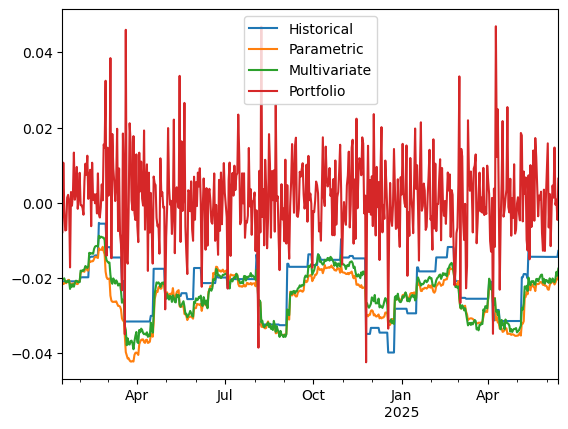

In [145]:
var_data.plot()
plt.show()

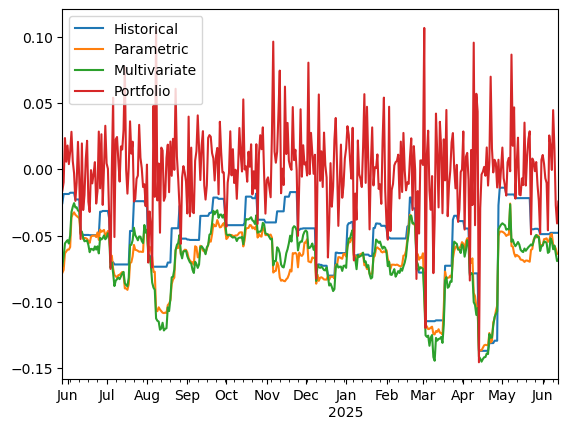

In [146]:
current_var_data.plot()
plt.show()


In [147]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.030948,0.01354,0.017408
Kupiec Stat,4.545134,20.124762,15.280029
P-value,0.033012,0.000007,0.000093


In [148]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.073298,0.020942,0.018325
Kupiec Stat,3.840982,8.612157,10.546139
P-value,0.050014,0.003339,0.001164


# Principal Component Analysis

## Historical PCA

In [151]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77051589, 0.09829852, 0.05550346, 0.03899122, 0.03669091])

In [152]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.018408
ADAUSDT      0.019035
ALGOUSDT     0.020253
APTUSDT      0.018145
ARBUSDT      0.020799
ATOMUSDT     0.017421
AVAXUSDT     0.020131
BCHUSDT      0.015580
BNBUSDT      0.009000
BONKUSDT     0.025806
BTCUSDT      0.010009
CAKEUSDT     0.018502
CRVUSDT      0.021401
DOGEUSDT     0.019756
DOTUSDT      0.018094
ENSUSDT      0.021701
ETCUSDT      0.016779
ETHUSDT      0.014734
FDUSDUSDT    0.000072
FETUSDT      0.023648
FILUSDT      0.019992
FLOKIUSDT    0.025042
GRTUSDT      0.022149
HBARUSDT     0.018900
ICPUSDT      0.018211
IMXUSDT      0.021196
INJUSDT      0.021861
JASMYUSDT    0.022058
LDOUSDT      0.022234
LINKUSDT     0.018509
LTCUSDT      0.013706
MKRUSDT      0.014132
NEARUSDT     0.022348
NEXOUSDT     0.011394
OMUSDT       0.014630
OPUSDT       0.021297
PAXGUSDT     0.000101
PEPEUSDT     0.026007
QNTUSDT      0.015309
SANDUSDT     0.021416
SEIUSDT      0.021651
SHIBUSDT     0.018907
SOLUSDT      0.016922
STXUSDT      0.021365
SUIUSDT      0.018988
THETAUSDT 

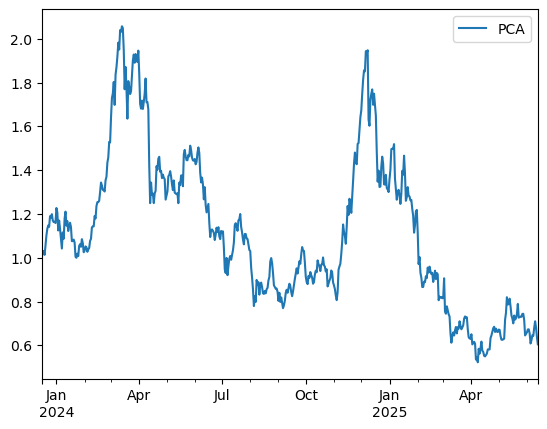

In [153]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

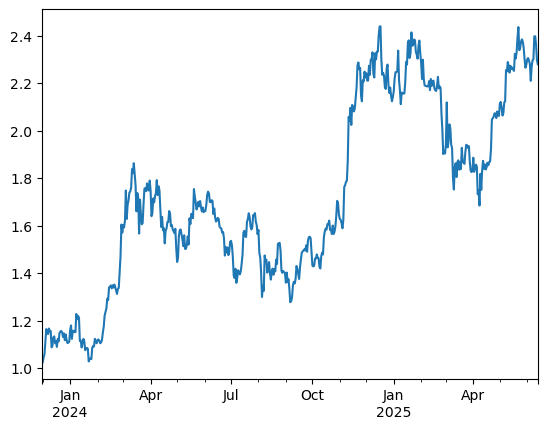

In [154]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [155]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
WBETHUSDT    0.485965
ETHUSDT      0.486149
ETCUSDT      0.500477
DOTUSDT      0.513245
ATOMUSDT     0.536863
AVAXUSDT     0.573279
FILUSDT      0.580478
NEXOUSDT     0.582166
WBTCUSDT     0.605332
GRTUSDT      0.605383
BTCUSDT      0.605667
ARBUSDT      0.618459
LINKUSDT     0.625361
VETUSDT      0.641268
ALGOUSDT     0.655388
SOLUSDT      0.682971
THETAUSDT    0.684068
IMXUSDT      0.705065
DOGEUSDT     0.706624
dtype: float64

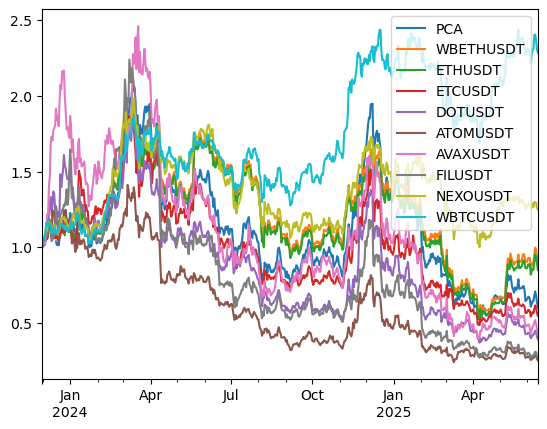

In [156]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

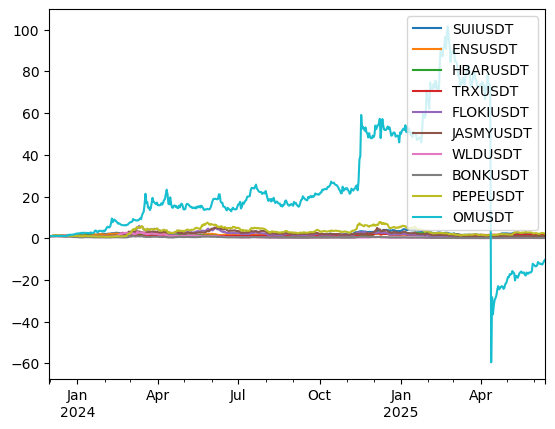

In [157]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [159]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.51297972, 0.3120631 , 0.07182649, 0.05999654, 0.04313414])

In [160]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.050541
SOLUSDT      0.091563
ETHUSDT      0.078272
JASMYUSDT    0.137221
TRXUSDT      0.036110
OMUSDT       0.256064
BBUSDT       0.163905
BNBUSDT      0.051034
PEPEUSDT     0.134163
PAXGUSDT     0.001129
Name: PC1, dtype: float64

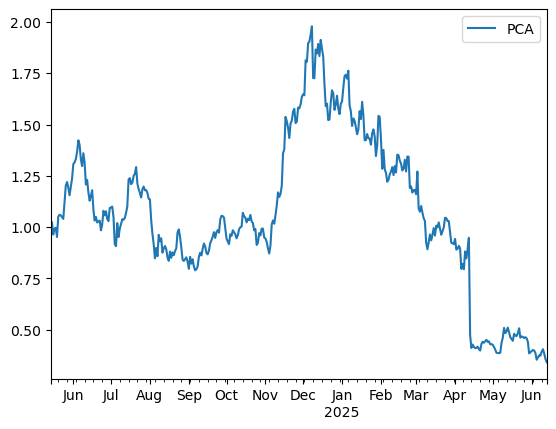

In [161]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()
plt.show()

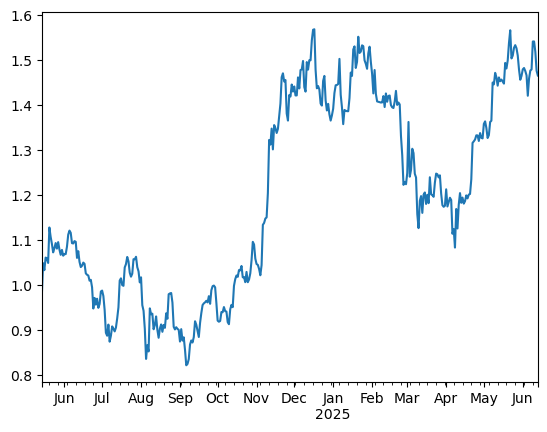

In [162]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [163]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.731881
SOLUSDT      0.763468
BTCUSDT      0.769171
BNBUSDT      0.777626
JASMYUSDT    0.980071
PAXGUSDT     1.015711
PEPEUSDT     1.018261
BBUSDT       1.030379
TRXUSDT      1.144413
dtype: float64

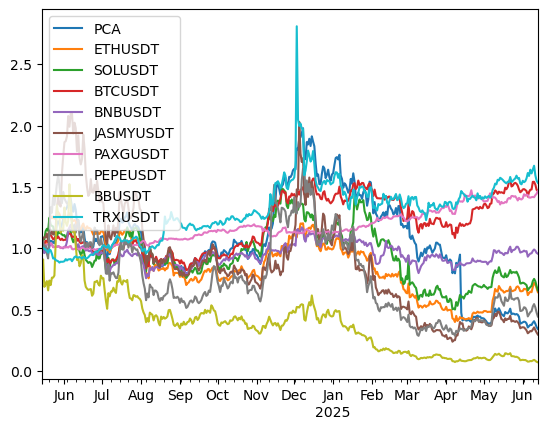

In [164]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [166]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.910094
BBUSDT       1.617343
JASMYUSDT    1.438522
SOLUSDT      1.274837
ETHUSDT      1.081090
BTCUSDT      1.000000
OMUSDT       0.972816
BNBUSDT      0.659582
TRXUSDT      0.326867
PAXGUSDT     0.029220
Name: BTCUSDT, dtype: float64

In [167]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       3.033966
PEPEUSDT     2.851721
OMUSDT       2.331276
JASMYUSDT    2.011033
SOLUSDT      1.449245
ETHUSDT      1.276639
BTCUSDT      1.000000
BNBUSDT      0.852292
TRXUSDT      0.364733
PAXGUSDT    -0.076353
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [169]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [170]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
ETHUSDT,0.262929
PEPEUSDT,0.249422
JASMYUSDT,0.196604
TRXUSDT,0.173763
OMUSDT,0.118625
SOLUSDT,0.116559
BTCUSDT,0.037376
BBUSDT,-0.023820
BNBUSDT,-0.053355
PAXGUSDT,-0.131696


### Regression to PCA

In [172]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.5915050967334765

In [173]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.370105
BNBUSDT      1.233887
PCA          1.000000
ETHUSDT      0.979947
SOLUSDT      0.759512
JASMYUSDT    0.493810
PEPEUSDT     0.481406
BBUSDT       0.436251
TRXUSDT      0.299929
PAXGUSDT     0.229058
OMUSDT       0.108588
dtype: float64

In [174]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT      1.961154
BTCUSDT      1.880505
SOLUSDT      1.229485
TRXUSDT      1.180574
ETHUSDT      1.166848
PCA          1.000000
JASMYUSDT    0.863280
PEPEUSDT     0.628693
OMUSDT       0.609479
BBUSDT       0.526774
PAXGUSDT    -0.933250
dtype: float64

### Correlation Matrix

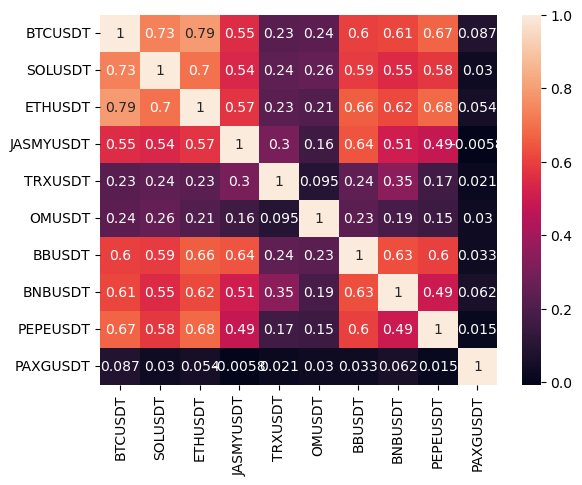

In [176]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

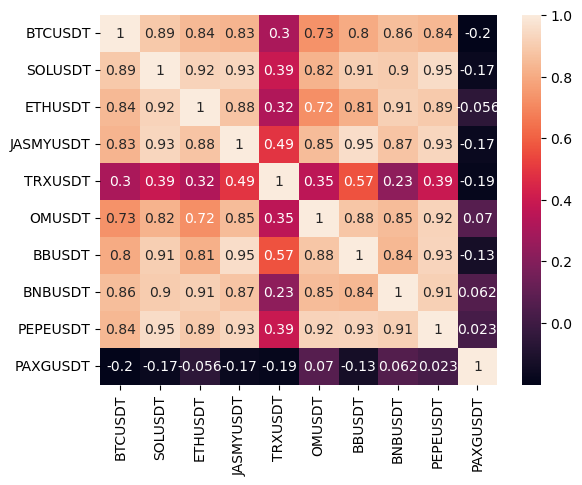

In [177]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [178]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [179]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

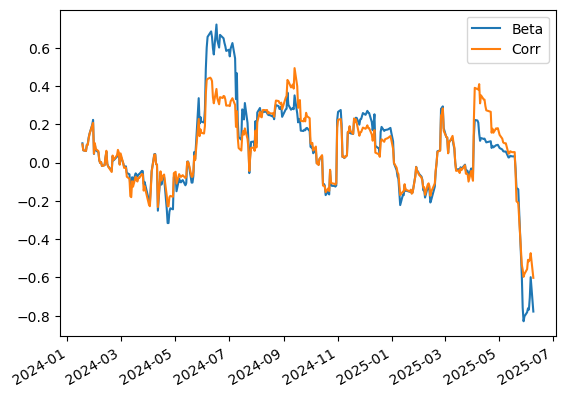

In [180]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [182]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,SOLUSDT,ETHUSDT,JASMYUSDT,TRXUSDT,OMUSDT,BBUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.000000,0.483879,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.000000,0.000000,0.000000,0.150876,0.222957,0.626168,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.932091,0.000000,0.000000,0.000000,0.000000,0.067909
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.223616,0.000000,0.003604,0.000000,0.000000,0.772780
2024-07-22,0.260704,0.086231,0.000000,0.000000,0.238042,0.019283,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.453755,0.000000,0.000000,0.000000,0.000000,0.546245
2024-09-02,0.000000,0.000000,0.000000,0.000000,0.564814,0.435186,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.000000,0.000000,0.166022,0.000000,0.526886,0.176734,0.000000,0.000000,0.130357,0.000000


In [ ]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

In [ ]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

In [ ]:
git.create_or_replace_notebook("Prod.ipynb")